In [1]:
from os import listdir

#configure train dataset
train_root_path = "./the-simpsons-characters-dataset/simpsons_dataset"
character_directories = listdir(train_root_path)
character_directories.remove('.DS_Store')
print("Train: {}".format(character_directories[:5]))

#configure test dataset
test_root_path = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
test_image_names = listdir(test_root_path)
test_image_names.remove('.DS_Store')
print("Test: {}".format(test_image_names[:5]))


Train: ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum']
Test: ['abraham_grampa_simpson_0.jpg', 'abraham_grampa_simpson_1.jpg', 'abraham_grampa_simpson_10.jpg', 'abraham_grampa_simpson_11.jpg', 'abraham_grampa_simpson_12.jpg']


### Calculate mean width and lenght from test images

In [2]:
import os, random
from scipy.misc import imread, imresize

width = 0
lenght = 0
num_test_images = len(test_image_names)

for i in range(num_test_images):
    path_file = os.path.join(test_root_path, test_image_names[i])
    image = imread(path_file)
    width += image.shape[0]
    lenght += image.shape[1]

width_mean = width//num_test_images
lenght_mean = lenght//num_test_images
dim_size = (width_mean + lenght_mean) // 2

print("Width mean: {}".format(width_mean))
print("Lenght mean: {}".format(lenght_mean))
print("Size mean dimension: {}".format(dim_size))

Width mean: 152
Lenght mean: 147
Size mean dimension: 149


In [3]:
#(149, 147), so we can redefine as (150, 150)
dim_size = 150

### Show some test examples

Label:principal_skinner, Image:940, Shape:(149, 206, 3)


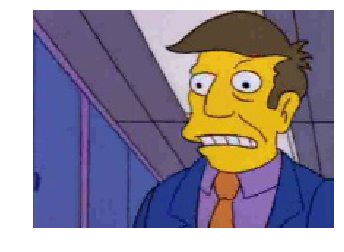

In [5]:
import matplotlib.pyplot as plt

idx = random.randint(0, num_test_images)
sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
path_file = os.path.join(test_root_path, sample_file)
sample_image = imread(path_file)

print("Label:{}, Image:{}, Shape:{}".format('_'.join(sample_name), idx, sample_image.shape))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

### Making batches (resized)

In [74]:
def get_num_of_samples():
    count = 0
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        count += len(listdir(path))
        
    return count

def get_batch(batch_init, batch_size):
    data = {'image':[], 'label':[]}
    character_batch_size = batch_size//len(character_directories)
    character_batch_init = batch_init//len(character_directories)
    character_batch_end = character_batch_init + character_batch_size

    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        images_list = listdir(path)
        for i in range(character_batch_init, character_batch_end):
            #if this character has small number of features
            #we repeat them
            if i >= len(images_list):
                p = i % len(images_list)
            else:
                p = i
                
            path_file = os.path.join(path, images_list[p])
            image = imread(path_file)
            #all with the same shape
            image = imresize(image, (dim_size, dim_size))
            data['image'].append(image)
            data['label'].append(character)
    
    return data

def get_batches(num_batches, batch_size, verbose=False):
    #check number of batches with the maximum
    max_num_batches = num_samples//batch_size - 1
    if verbose:
        print("Batches:{} Size:{}".format(num_batches, batch_size))
    assert num_batches <= max_num_batches, "Surpassed the maximum number of batches"
        
    for i in range(0, num_batches):
        init = i * batch_size
        if verbose:
            print("batch-{} yielding images from {} to {}...".format(i, init, init+batch_size))
        
        yield get_batch(init, batch_size)

In [75]:
#num max of samples
num_samples = get_num_of_samples()
print("Number of samples:{}".format(num_samples))

#testing generator
batch_size = 500

for b in get_batches(10, batch_size, verbose=True):
    print("retrieved {} images".format(len(b['image'])))

Number of samples:19413
Batches:10 Size:500
batch-0 yielding images from 0 to 500...
retrieved 500 images
batch-1 yielding images from 500 to 1000...
retrieved 500 images
batch-2 yielding images from 1000 to 1500...
retrieved 500 images
batch-3 yielding images from 1500 to 2000...
retrieved 500 images
batch-4 yielding images from 2000 to 2500...
retrieved 500 images
batch-5 yielding images from 2500 to 3000...
retrieved 500 images
batch-6 yielding images from 3000 to 3500...
retrieved 500 images
batch-7 yielding images from 3500 to 4000...
retrieved 500 images
batch-8 yielding images from 4000 to 4500...
retrieved 500 images
batch-9 yielding images from 4500 to 5000...
retrieved 500 images


### Preprocessing data

In [32]:
from sklearn import preprocessing

#num characters
num_characters = len(character_directories)

#normalize
def normalize(x):
    #we use the feature scaling to have all the batches
    #in the same space, that is (0,1)
    return (x - np.amin(x))/(np.amax(x) - np.amin(x))

#one-hot encode
lb = preprocessing.LabelBinarizer()
lb = lb.fit(character_directories)

def one_hot(label):
    return lb.transform([label])


### Storing preprocessed batches on disk

In [76]:
num_batches = 10
batch_size = 500

In [77]:
import pickle

cnt_images = 0
for cnt, b in enumerate(get_batches(num_batches, batch_size)):
    data = {'image':[], 'label':[]}

    for i in range(batch_size):
        image = np.array( b['image'][i] )
        label = np.array( b['label'][i] )
        #label = label.reshape([-1,:])
        data['image'].append(normalize(image))
        data['label'].append(one_hot(label)[-1,:])
        cnt_images += 1
    
    with open("simpson_train_{}.pkl".format(cnt), 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    
print("Loaded {} train images and stored on disk".format(cnt_images))

Loaded 5000 train images and stored on disk


In [79]:
#testing load from file
import pickle

with open('simpson_train_0.pkl', 'rb') as file:
    data = pickle.load(file)
    print(data['label'][0])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Building the Network

In [11]:
import tensorflow as tf

#helpers
def convolution(inputs, kernel_shape, stride_shape, output_depth):
    #convolution variables
    input_depth = inputs.get_shape().as_list()[3]
    filter_shape = kernel_shape + (input_depth, output_depth)
    dev = 1/np.sqrt(kernel_shape[0]*kernel_shape[1])
    filter_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=dev), name="filter_")
    stride_shape = (1,) + stride_shape + (1,)
    pool_shape = stride_shape
    bias_ = tf.Variable(tf.truncated_normal([output_depth], stddev=dev), name="bias_")
    
    #convolution
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    
    #pooling
    conv = tf.nn.max_pool(conv, pool_shape, stride_shape, padding='SAME')
    
    return conv

def classifier(inputs, num_outputs):
    #classifier variables
    num_inputs = inputs.get_shape().as_list()[1]
    dev = 1/np.sqrt(num_inputs)
    weights = tf.Variable(tf.truncated_normal((num_inputs,)+num_outputs, stddev=dev), name="weights")
    bias = tf.Variable(tf.truncated_normal(num_outputs, stddev=dev), name="bias")

    #classifier
    logits = tf.add(tf.matmul(inputs, weights), bias)

    return logits

In [44]:
##building the network
import numpy as np

#remove previous weights, bias, etc
tf.reset_default_graph()

#shape
image_shape = (dim_size, dim_size, 3)
label_shape = (num_characters,)

#data
X = tf.placeholder(tf.float32, (None,) + image_shape)
y = tf.placeholder(tf.float32, (None,) + label_shape)

#conv
print(X.get_shape().as_list())
conv = convolution(X, (5,5), (2,2), 16)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 32)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 64)
print(conv.get_shape().as_list())
    
#before classifier
flatten_shape = np.prod(conv.get_shape().as_list()[1:])
flatten = tf.reshape(conv, [-1,flatten_shape])

#classifying
num_outputs = label_shape
logits = classifier(flatten, (40,))
logits = tf.nn.dropout(logits, 0.5)
logits = classifier(logits, num_outputs)

print("Inputs shape: {}".format(X.get_shape().as_list()[1:]))
print("Flatten shape: {}".format(flatten_shape))
print("Outputs shape: {}".format(logits.get_shape().as_list()[1]))

[None, 150, 150, 3]
[None, 38, 38, 16]
[None, 10, 10, 32]
[None, 3, 3, 64]
Inputs shape: [150, 150, 3]
Flatten shape: 576
Outputs shape: 20


In [45]:
#loss and optmizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

#accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [78]:
from sklearn.model_selection import train_test_split

##Train the model
x_train = []
y_train = []
x_val = []
y_val = []

##
epochs = 20

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for e in range(epochs):
    
    for i in range(num_batches):
        with open("simpson_train_{}.pkl".format(i), 'rb') as file:
            data = pickle.load(file)
            x_train, x_val, y_train, y_val = train_test_split(data['image'], data['label'], test_size=0.2, random_state=42)
            feed_dict = {X: x_train, y: y_train}
            train_loss, _ = sess.run([cost, optimizer], feed_dict)
            
            feed_dict = {X: x_val, y: y_val}
            val_loss, acc = sess.run([cost, accuracy], feed_dict)
            
    print("Epoch:{} Training Loss:{:.4f} Validation Loss:{:.4f} Accuracy:{:.4f}".format(e, train_loss, val_loss, acc))

Epoch:0 Training Loss:3.3083 Validation Loss:3.2115 Accuracy:0.0700
Epoch:1 Training Loss:3.0421 Validation Loss:2.9745 Accuracy:0.1200
Epoch:2 Training Loss:2.9490 Validation Loss:2.9618 Accuracy:0.0900
Epoch:3 Training Loss:2.8730 Validation Loss:2.9545 Accuracy:0.1100
Epoch:4 Training Loss:2.8081 Validation Loss:2.8268 Accuracy:0.1300
Epoch:5 Training Loss:2.7488 Validation Loss:2.6629 Accuracy:0.2000
Epoch:6 Training Loss:2.5876 Validation Loss:2.7023 Accuracy:0.1700
Epoch:7 Training Loss:2.5133 Validation Loss:2.4890 Accuracy:0.2200
Epoch:8 Training Loss:2.3429 Validation Loss:2.4845 Accuracy:0.1600
Epoch:9 Training Loss:2.2648 Validation Loss:2.3693 Accuracy:0.2700
Epoch:10 Training Loss:2.1123 Validation Loss:2.3514 Accuracy:0.2800
Epoch:11 Training Loss:2.1240 Validation Loss:2.4021 Accuracy:0.2600
Epoch:12 Training Loss:1.9299 Validation Loss:2.0763 Accuracy:0.3700
Epoch:13 Training Loss:1.8776 Validation Loss:2.1049 Accuracy:0.4000
Epoch:14 Training Loss:1.8495 Validation Los

### Testing model

Label: Apu Nahasapeemapetilon
Prediction: Apu Nahasapeemapetilon


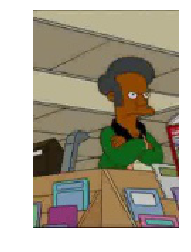

In [112]:
#prediction
idx = random.randint(0, num_test_images)
sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
path_file = os.path.join(test_root_path, sample_file)
sample_image = imread(path_file)
idx = int(random.uniform(0, len(y_val)))
    
test_image = sample_image
test_label = ' '.join([s.capitalize() for s in sample_name])

test_image_norm = normalize(imresize(sample_image, (dim_size, dim_size)))

prediction = sess.run(logits, {X:[test_image_norm]})
prediction = lb.inverse_transform(prediction)

#showing
print("Label: {}".format(test_label))
prediction = ' '.join([s.capitalize() for s in prediction[0].split('_')])
print("Prediction: {}".format(prediction))

plt.imshow(test_image)
plt.axis('off')
plt.show()